In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import metrics


df = pd.read_csv('traffic.csv', parse_dates=['DateTime'])

print(df.head())
print(df.info())

             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None


In [108]:
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Year'] = df['DateTime'].dt.year
df['DayName'] = df['DateTime'].dt.day_name()

X = df[['Junction', 'Hour', 'Day', 'Month', 'DayOfWeek', 'Year']]
y = df['Vehicles']

X.head()

,Junction,Hour,Day,Month,DayOfWeek,Year
0,1,0,1,11,6,2015
1,1,1,1,11,6,2015
2,1,2,1,11,6,2015
3,1,3,1,11,6,2015
4,1,4,1,11,6,2015


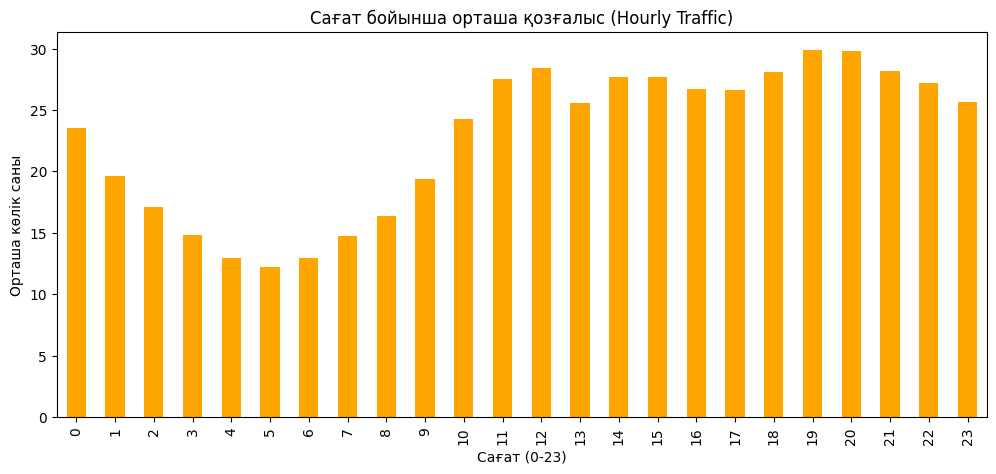

In [109]:
plt.figure(figsize=(12, 5))
hourly_traffic = df.groupby('Hour')['Vehicles'].mean()
hourly_traffic.plot(kind='bar', color='orange')
plt.title('Сағат бойынша орташа қозғалыс (Hourly Traffic)')
plt.xlabel('Сағат (0-23)')
plt.ylabel('Орташа көлік саны')
plt.show()


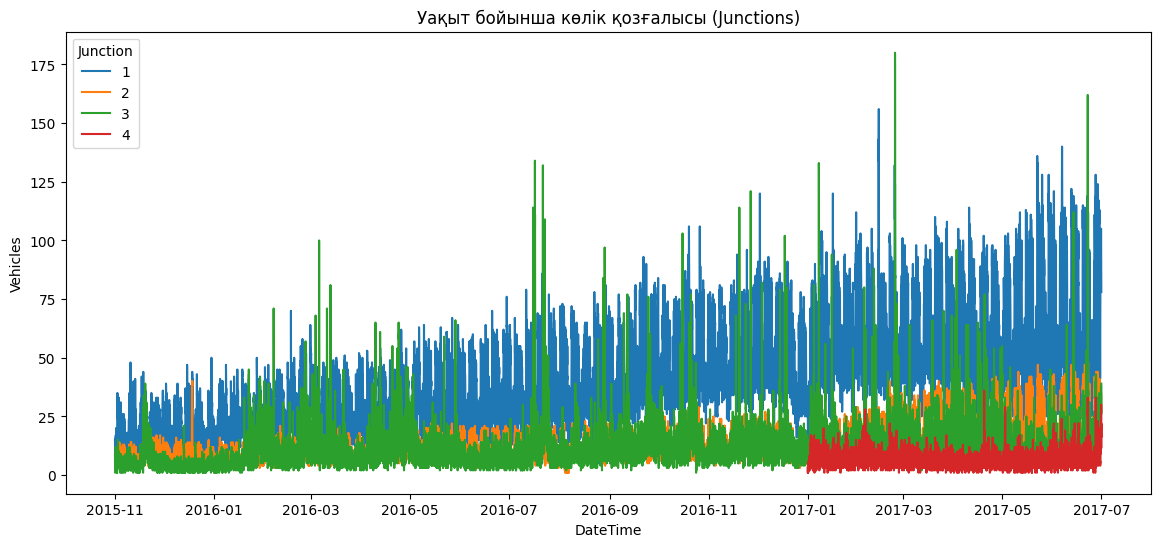

In [110]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='DateTime', y='Vehicles', hue='Junction', palette='tab10')
plt.title('Уақыт бойынша көлік қозғалысы (Junctions)')
plt.show()

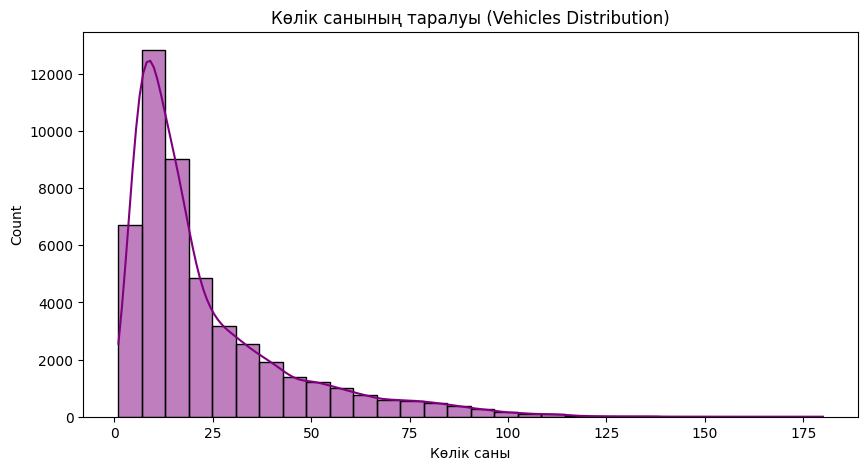

In [111]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Vehicles'], kde=True, bins=30, color='purple')
plt.title('Көлік санының таралуы (Vehicles Distribution)')
plt.xlabel('Көлік саны')
plt.show()

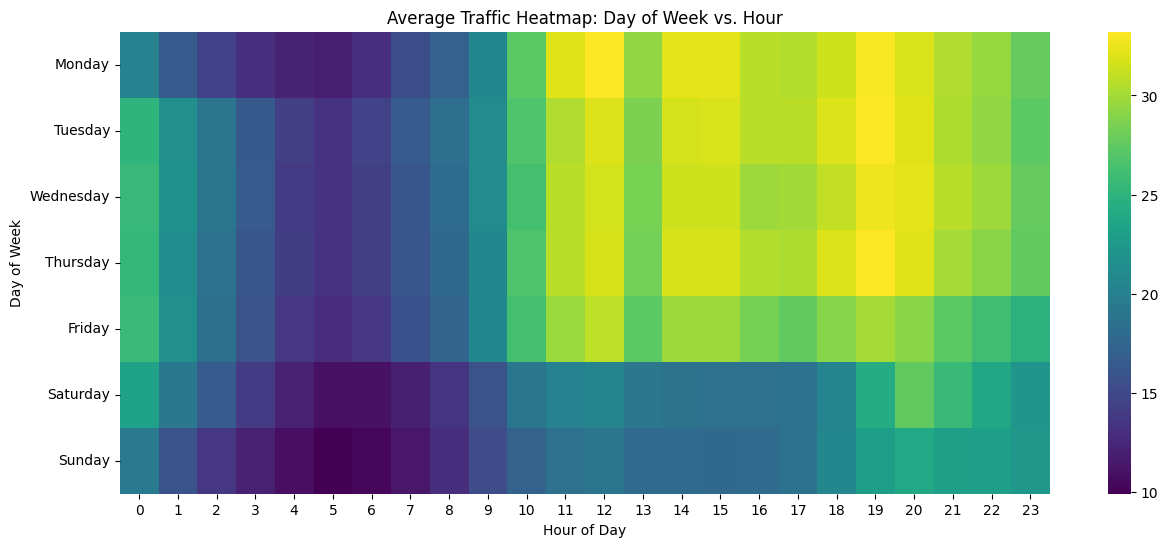

In [112]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot_table = df.pivot_table(values='Vehicles', index='DayName', columns='Hour', aggfunc='mean')
pivot_table = pivot_table.reindex(day_order)

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=False)
plt.title('Average Traffic Heatmap: Day of Week vs. Hour')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)
print('--------------------------------')
print(X_test_scaled)
print('--------------------------------')

[[ 0.84686545  0.6499471  -0.08022776  1.71181804 -0.99922782 -2.06154162]
 [ 0.84686545  0.9395447  -1.22012873  1.71181804  1.00456314 -2.06154162]
 [ 0.84686545  0.3603495  -0.30820795 -0.52807276 -0.49828008 -0.43874786]
 ...
 [ 0.84686545  1.51873989 -0.87815844  1.43183169 -0.99922782 -0.43874786]
 [-1.22198418  1.22914229 -1.10613863  1.71181804  1.50551088 -2.06154162]
 [-0.18755936 -1.23243728  0.60371283  1.71181804 -1.50017556 -2.06154162]]
--------------------------------
[[-0.18755936 -0.50844329  0.83169302  1.71181804  0.5036154  -0.43874786]
 [ 0.84686545  1.22914229  1.40164351  0.59187264  1.50551088 -0.43874786]
 [ 0.84686545 -0.79804088  0.94568312 -0.52807276 -1.50017556  1.18404591]
 ...
 [-0.18755936 -1.08763848 -0.76416834 -1.08804546  0.00266766  1.18404591]
 [ 1.88129026  1.37394109 -0.08022776 -1.08804546 -0.49828008  1.18404591]
 [-0.18755936  1.66353869 -0.99214853  0.87185899 -0.49828008 -0.43874786]]
--------------------------------


In [114]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV()
)

stacking_model.fit(X_train_scaled, y_train)
y_pred_stack = stacking_model.predict(X_test_scaled)

In [115]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} Performance ---")
    print('MAE:', metrics.mean_absolute_error(y_true, y_pred)) #mean-actual
    print('MSE:', metrics.mean_squared_error(y_true, y_pred))
    print('RMSE:', metrics.root_mean_squared_error(y_true,y_pred)) #sqrt(mse)
    print('R2 Score:', metrics.r2_score(y_true, y_pred))
    print("\n")

evaluate_model(y_test, y_pred_lin, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_stack, "Stacking")

--- Linear Regression Performance ---
MAE: 9.637676096030772
MSE: 163.1248444908932
RMSE: 12.77203368657056
R2 Score: 0.5997395466491757


--- Random Forest Performance ---
MAE: 2.395125727348296
MSE: 12.612214910640066
RMSE: 3.551368033679425
R2 Score: 0.9690533292237244


--- Gradient Boosting Performance ---
MAE: 4.011521447900654
MSE: 40.06111571486642
RMSE: 6.329385097690487
R2 Score: 0.9017017892779206


--- Stacking Performance ---
MAE: 2.384663902423707
MSE: 12.591664499371019
RMSE: 3.5484735449726856
R2 Score: 0.9691037538966598




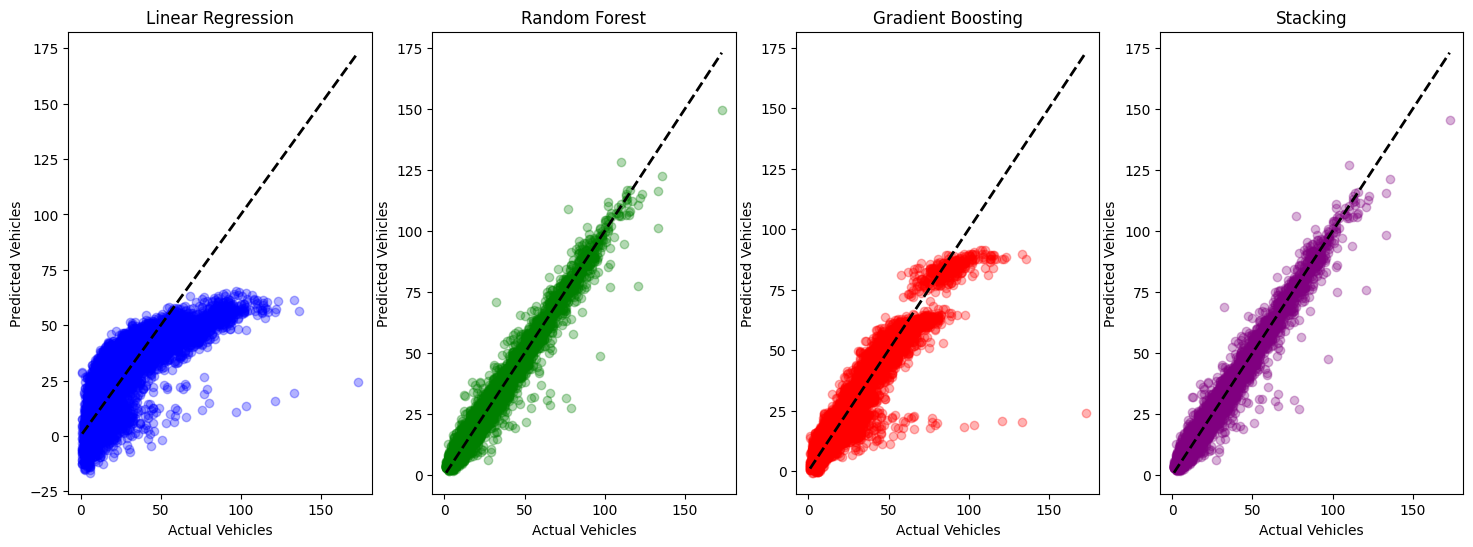

In [116]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.scatter(y_test, y_pred_lin, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear Regression')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')

plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')

plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_gb, alpha=0.3, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Gradient Boosting')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')

plt.subplot(1, 4, 4)
plt.scatter(y_test, y_pred_stack, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Stacking')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')

plt.show()